# **Social Media Analytics Project - Healthcare Provider Fraud Analysis**

## **Data Loading and Cleaning**

In [1]:
# Loading Relevant Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import xgboost as xgb
import networkx as nx
import leidenalg as la


In [95]:
# !pip install leidenalg

In [2]:
# Loading data train
df_bene_train = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
df_inpat_train = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
df_outpat_train = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
df_provider_train = pd.read_csv("Train-1542865627584.csv")


# Loading data test
df_bene_test = pd.read_csv('Test_Beneficiarydata-1542969243754.csv')
df_inpat_test = pd.read_csv('Test_Inpatientdata-1542969243754.csv')
df_outpat_test = pd.read_csv('Test_Outpatientdata-1542969243754.csv')
df_provider_test = pd.read_csv("Test-1542969243754.csv")


# State and county mapping
df_state = pd.read_csv('us-state-ansi-fips.csv')
df_county = pd.read_csv('state_and_county_fips_master.csv')

### **Beneficiary Data**

In [3]:
df_bene_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [4]:
df_bene_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [5]:
df_bene_train.describe()

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,1.570932,1.254511,25.666734,374.424745,11.907727,11.910145,1.667817,1.506322,1.687643,1.880041,...,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,0.324914,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,1.000000,1.000000,11.000000,141.000000,12.000000,12.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,2.000000,1.000000,25.000000,340.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,2.000000,1.000000,39.000000,570.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000
max,2.000000,5.000000,54.000000,999.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [6]:
# for col in df_bene_train.columns:
#     print("Column {}:\n Unique Values: {}\n Rows with null values:{}\n Rows with non null values:{}\n\n".format(col,df_bene_train[col].nunique(),df_bene_train[col].isnull().sum(),df_bene_train[col].count()))

In [7]:
df_bene_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [8]:
# Since we have last beneficary death recoreded on 2009 we will calculate age from 2009
#df_bene_train['DOD'].unique()
df_bene_train['Age'] = pd.to_datetime('2010').year - pd.to_datetime(df_bene_train['DOB']).dt.year

In [9]:
df_bene_train['Alive'] =df_bene_train['DOD'].apply(lambda row: 1 if pd.isnull(row) else 0)

In [10]:
df_bene_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [11]:
df_bene_train['RenalDiseaseIndicator'].replace('Y','1',inplace=True)

In [12]:
# Converting 2 to 0 in Cronic Columns - 1 - Yes, 0 - No

col = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_KidneyDisease', 'ChronicCond_Cancer','ChronicCond_ObstrPulmonary', 'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis','ChronicCond_stroke']
# for i in col:
#     print("{}:{}".format(i,df_bene_train[i].unique()))
for i in col:
    df_bene_train[i] = df_bene_train[i].apply(lambda x: 0 if x ==2 else 1)


In [13]:
df_bene_train['ChronicCount'] = df_bene_train[col].sum(axis=1)

In [14]:
df_bene_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [15]:
#Cleaned Beneficary Columns
df_bene_train = df_bene_train[['BeneID','Age','Alive','Gender','Race','RenalDiseaseIndicator','State','County','NoOfMonths_PartACov','NoOfMonths_PartBCov','ChronicCount','IPAnnualReimbursementAmt','IPAnnualDeductibleAmt','OPAnnualReimbursementAmt','OPAnnualDeductibleAmt']]
df_bene_train.head()

,BeneID,Age,Alive,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCount,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,67,1,1,1,0,39,230,12,12,7,36000,3204,60,70
1,BENE11002,74,1,2,1,0,39,280,12,12,0,0,0,30,50
2,BENE11003,74,1,1,1,0,52,590,12,12,2,0,0,90,40
3,BENE11004,88,1,1,1,0,39,270,12,12,6,0,0,1810,760
4,BENE11005,75,1,1,1,0,24,680,12,12,2,0,0,1790,1200


### **Inpatient And Outpatient Data**

In [16]:
# Not useful- has correlation with other columns

# df_inpat_train['Pat_type'] = 1
# df_outpat_train['Pat_type'] = 0

In [17]:
df_inpat_train['Claim_process_time'] = pd.to_datetime(df_inpat_train['ClaimEndDt']) - pd.to_datetime(df_inpat_train['ClaimStartDt'])
df_inpat_train['Claim_process_time'] = df_inpat_train['Claim_process_time'].dt.days.astype(int)

In [18]:
df_outpat_train['Claim_process_time'] = pd.to_datetime(df_outpat_train['ClaimEndDt']) - pd.to_datetime(df_outpat_train['ClaimStartDt'])
df_outpat_train['Claim_process_time'] = df_outpat_train['Claim_process_time'].dt.days.astype(int)

In [19]:
# for col in df_inpat_train.columns:
#      print("Column {}:\n Unique Values: {}\n Rows with null values:{}\n Rows with non null values:{}\n\n".format(col,df_inpat_train[col].nunique(),df_inpat_train[col].isna().sum(),df_inpat_train[col].count()))
#      print("Column {}:Percentage of null values is {}".format(col,round((df_inpat_train[col].isna().sum()/df_inpat_train[col].shape[0])*100,2)))

In [20]:
# for col in df_outpat_train.columns:
#     print("Column {}:\n Unique Values: {}\n Rows with null values:{}\n Rows with non null values:{}\n\n".format(col,df_outpat_train[col].nunique(),df_outpat_train[col].isna().sum(),df_outpat_train[col].count()))
#     print("Column {}:Percentage of null values is {}".format(col,round((df_outpat_train[col].isna().sum()/df_outpat_train[col].shape[0])*100,2)))


In [21]:
# df_inpat_train.info()

In [22]:
df_inpat_train.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Claim_process_time'],
      dtype='object')

In [23]:
df_inpat_train.drop(columns=['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode'], inplace=True)


In [24]:
df_outpat_train.drop(columns=['ClaimStartDt', 'ClaimEndDt'], inplace=True)


In [26]:
df_pat_train = pd.concat([df_inpat_train, df_outpat_train], ignore_index=True)

In [27]:
df_pat_train

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,ClmDiagnosisCode_1,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_process_time
0,BENE11001,CLM46614,PRV55912,26000,PHY390922,NaN,NaN,7866,1068.0,1970,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,BENE11001,CLM66048,PRV55907,5000,PHY318495,PHY318495,NaN,6186,1068.0,6186,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,2
2,BENE11001,CLM68358,PRV56046,5000,PHY372395,NaN,PHY324689,29590,1068.0,29623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,BENE11011,CLM38412,PRV52405,5000,PHY369659,PHY392961,PHY349768,431,1068.0,43491,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,8
4,BENE11014,CLM63689,PRV56614,10000,PHY379376,PHY398258,NaN,78321,1068.0,042,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,0.0,2163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
558207,BENE159198,CLM551294,PRV53702,400,PHY423019,PHY332284,NaN,NaN,0.0,07041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
558208,BENE159198,CLM596444,PRV53676,60,PHY361063,NaN,NaN,NaN,0.0,V570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
558209,BENE159198,CLM636992,PRV53689,70,PHY403198,NaN,PHY419379,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [28]:
df_bene_train

,BeneID,Age,Alive,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCount,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,67,1,1,1,0,39,230,12,12,7,36000,3204,60,70
1,BENE11002,74,1,2,1,0,39,280,12,12,0,0,0,30,50
2,BENE11003,74,1,1,1,0,52,590,12,12,2,0,0,90,40
3,BENE11004,88,1,1,1,0,39,270,12,12,6,0,0,1810,760
4,BENE11005,75,1,1,1,0,24,680,12,12,2,0,0,1790,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,71,1,1,1,0,39,140,12,12,1,0,0,430,460
138552,BENE159195,72,1,2,1,0,49,530,12,12,2,0,0,880,100
138553,BENE159196,94,1,2,1,0,6,150,12,12,6,2000,1068,3240,1390
138554,BENE159197,80,1,1,1,0,16,560,12,12,3,0,0,2650,10


In [29]:
df_pat_train = df_pat_train.merge(df_bene_train,how= 'left', left_on='BeneID', right_on='BeneID')

In [30]:
df_pat_train = df_pat_train.merge(df_provider_train,how= 'left', left_on='Provider', right_on='Provider')

In [31]:
df_pat_train['OPAnnualAmt'] = df_pat_train[['OPAnnualDeductibleAmt','OPAnnualReimbursementAmt']].sum(axis=1)
df_pat_train['IPAnnualAmt'] = df_pat_train[['IPAnnualDeductibleAmt','IPAnnualReimbursementAmt']].sum(axis=1)

In [32]:
## Identifying columns with more than 50% nulls
for col in df_pat_train.columns:
    print("Column {}:Percentage of null values is {}".format(col,round((df_pat_train[col].isna().sum()/df_pat_train[col].shape[0])*100,2)))



Column BeneID:Percentage of null values is 0.0
Column ClaimID:Percentage of null values is 0.0
Column Provider:Percentage of null values is 0.0
Column InscClaimAmtReimbursed:Percentage of null values is 0.0
Column AttendingPhysician:Percentage of null values is 0.27
Column OperatingPhysician:Percentage of null values is 79.5
Column OtherPhysician:Percentage of null values is 64.22
Column ClmAdmitDiagnosisCode:Percentage of null values is 73.86
Column DeductibleAmtPaid:Percentage of null values is 0.16
Column ClmDiagnosisCode_1:Percentage of null values is 1.87
Column ClmDiagnosisCode_2:Percentage of null values is 35.04
Column ClmDiagnosisCode_3:Percentage of null values is 56.46
Column ClmDiagnosisCode_4:Percentage of null values is 70.52
Column ClmDiagnosisCode_5:Percentage of null values is 79.95
Column ClmDiagnosisCode_6:Percentage of null values is 84.88
Column ClmDiagnosisCode_7:Percentage of null values is 88.14
Column ClmDiagnosisCode_8:Percentage of null values is 90.43
Column

In [33]:
df_pat_train.drop(['OtherPhysician','ClmAdmitDiagnosisCode','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10','ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6','OPAnnualReimbursementAmt','OPAnnualDeductibleAmt','IPAnnualDeductibleAmt','IPAnnualReimbursementAmt'], axis =1,inplace= True)

In [34]:
df_pat_train['PotentialFraud'] =df_pat_train['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [40]:
# Droping rows where there are NaNs in any of the four columns
df_pat_train.dropna(subset=['BeneID', 'Provider', 'AttendingPhysician', 'OperatingPhysician'], inplace=True)

In [41]:
df_pat_train.shape

(114433, 23)

## **Correlation Matrix - Identifying And Removing Highly Correlated Features**

C:\Users\naray\AppData\Local\Temp\ipykernel_5564\1432923012.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df_pat_train.drop(['PotentialFraud'],axis=1).corr())>0.7,annot=True,fmt=".2f", linewidth=.5)


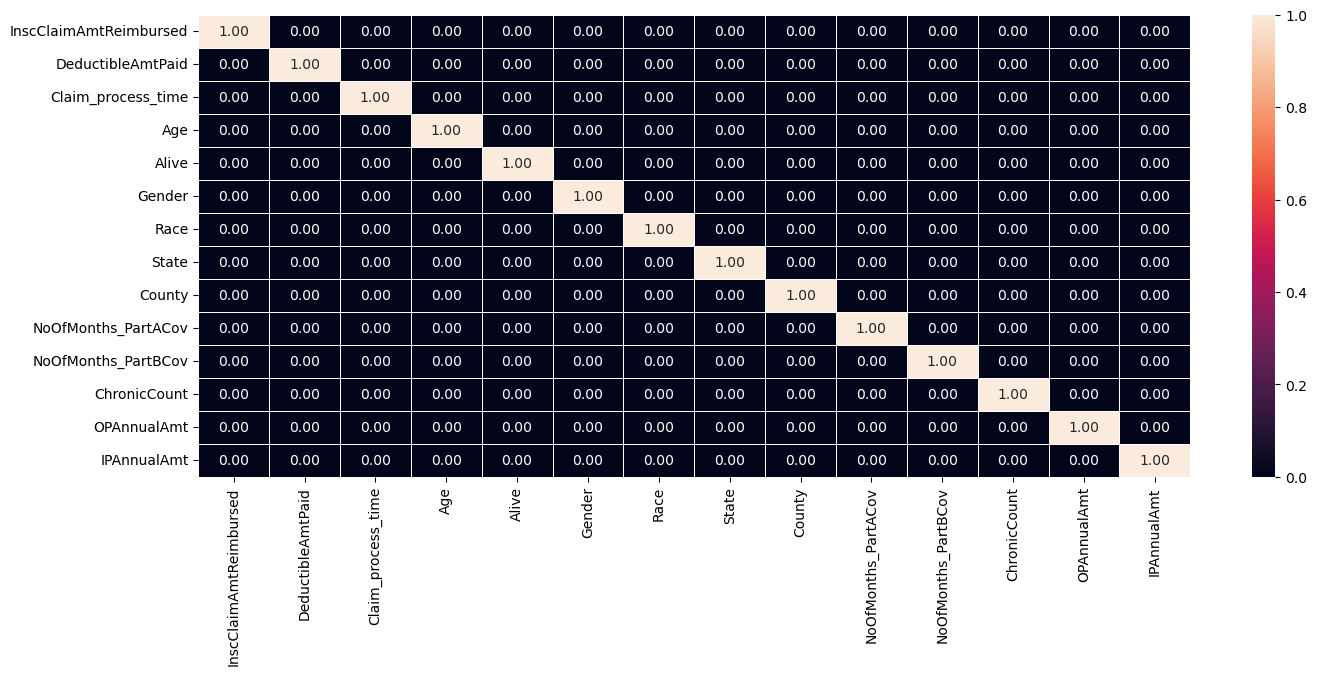

In [42]:
plt.figure(figsize=(16,6))
sns.heatmap(abs(df_pat_train.drop(['PotentialFraud'],axis=1).corr())>0.7,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [43]:
df_pat_train.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,DeductibleAmtPaid,ClmDiagnosisCode_1,ClmDiagnosisCode_2,Claim_process_time,...,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCount,PotentialFraud,OPAnnualAmt,IPAnnualAmt
1,BENE11001,CLM66048,PRV55907,5000,PHY318495,PHY318495,1068.0,6186,2948,2,...,1,0,39,230,12,12,7,0,130,39204
3,BENE11011,CLM38412,PRV52405,5000,PHY369659,PHY392961,1068.0,43491,2762,8,...,2,0,1,360,12,12,6,0,570,6068
4,BENE11014,CLM63689,PRV56614,10000,PHY379376,PHY398258,1068.0,042,3051,17,...,1,1,45,780,12,12,5,0,220,23396
5,BENE11017,CLM70950,PRV54986,8000,PHY402711,PHY402711,1068.0,1745,V4571,6,...,1,0,31,270,12,12,9,1,2240,24136
6,BENE11018,CLM32075,PRV54090,8000,PHY412314,PHY347494,1068.0,1536,73300,5,...,2,0,24,120,12,12,6,0,910,9068


In [44]:
df_pat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114433 entries, 1 to 558207
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  114433 non-null  object 
 1   ClaimID                 114433 non-null  object 
 2   Provider                114433 non-null  object 
 3   InscClaimAmtReimbursed  114433 non-null  int64  
 4   AttendingPhysician      114433 non-null  object 
 5   OperatingPhysician      114433 non-null  object 
 6   DeductibleAmtPaid       113892 non-null  float64
 7   ClmDiagnosisCode_1      113263 non-null  object 
 8   ClmDiagnosisCode_2      90556 non-null   object 
 9   Claim_process_time      114433 non-null  int32  
 10  Age                     114433 non-null  int64  
 11  Alive                   114433 non-null  int64  
 12  Gender                  114433 non-null  int64  
 13  Race                    114433 non-null  int64  
 14  RenalDiseaseIndicato

## **Modeling**

### **Iteration 1 : Without Graph Parameters**

##### **Splitting And Encoding Data**

In [45]:
# Separating X and Y
y = df_pat_train['PotentialFraud']
X =df_pat_train.drop(['PotentialFraud'], axis=1)

In [46]:
label_e = LabelEncoder()
X_encoded = X.apply(label_e.fit_transform)

In [47]:
# Splting data into train and test
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [48]:
# Categorical_Cols = ['BeneID', 'ClaimID', 'Provider','AttendingPhysician','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'Alive', 'Gender','Race', 'RenalDiseaseIndicator', 'State', 'County']
# Numerical_cols = ['InscClaimAmtReimbursed','DeductibleAmtPaid','Claim_process_time','Age','NoOfMonths_PartACov','NoOfMonths_PartBCov', 'ChronicCount','OPAnnualAmt', 'IPAnnualAmt']

#### **Random Forest**

In [49]:
model = RandomForestClassifier()

parameter_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("List of best parameters for Random Forest are :{}".format(grid_search.best_params_))
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy for best Random Model is {}%".format(round(metrics.accuracy_score(y_test, y_pred)*100,2)))


# accuracy_chart[2] = ['I1','Random Forest',round(metrics.accuracy_score(y_test, y_pred)*100,2)]

List of best parameters for Random Forest are :{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for best Random Model is 66.33%


### **XG Boost**

In [50]:
model = xgb.XGBClassifier()
parameter_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, scoring='accuracy', cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("List of best parameters for XG Boost are :{}".format(grid_search.best_params_))

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the accuracy of the best model on the test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy for best XG Boost on test set is {}%".format(round(accuracy * 100, 2)))


List of best parameters for XG Boost are :{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy for best XG Boost on test set is 81.65%


### **Iteration 2 : With Graph Parameters**

#### **Creating Bipartite Graph - Provider and Attending Physician**

In [79]:
G = nx.Graph()

providers = df_pat_train['Provider'].unique()
physicians = df_pat_train['AttendingPhysician'].unique()

G.add_nodes_from(providers, bipartite='provider')
G.add_nodes_from(physicians, bipartite='physician')

edges = [(row['Provider'], row['AttendingPhysician']) for index, row in df_pat_train.iterrows()]
G.add_edges_from(edges)

### Degree
degree_centrality_P_AP = nx.degree_centrality(G)
df_degree_centrality_P_AP = pd.DataFrame(degree_centrality_P_AP.items(), columns=['Provider', 'Degree_Centrality_P_AP'])
## Closeness Centrality
closeness_centrality_P_AP = nx.closeness_centrality(G)
df_closeness_centrality_P_AP = pd.DataFrame(closeness_centrality_P_AP.items(), columns=['Provider', 'Closeness_Centrality_P_AP'])
## Eigenvector Centrality
eigenvector_centrality_P_AP = nx.eigenvector_centrality(G,max_iter=1000)
df_eigenvector_centrality_P_AP = pd.DataFrame(eigenvector_centrality_P_AP.items(), columns=['Provider', 'Eigenvector_Centrality_P_AP'])
## Birank Calculation
birank_scores_P_AP = nx.pagerank(nx.bipartite.weighted_projected_graph(G, providers))
df_birank_scores_P_AP = pd.DataFrame(birank_scores_P_AP.items(), columns=['Provider', 'Birank_score_P_AP'])

#### **Creating Bipartite Graph - Provider and Operating Physician**

In [80]:
G = nx.Graph()

providers = df_pat_train['Provider'].unique()
physicians = df_pat_train['OperatingPhysician'].unique()

G.add_nodes_from(providers, bipartite='provider')
G.add_nodes_from(physicians, bipartite='physician')

edges = [(row['Provider'], row['OperatingPhysician']) for index, row in df_pat_train.iterrows()]
G.add_edges_from(edges)

### Degree
degree_centrality_P_OP = nx.degree_centrality(G)
df_degree_centrality_P_OP = pd.DataFrame(degree_centrality_P_OP.items(), columns=['Provider', 'Degree_Centrality_P_OP'])
## Closeness Centrality
closeness_centrality_P_OP = nx.closeness_centrality(G)
df_closeness_centrality_P_OP = pd.DataFrame(closeness_centrality_P_OP.items(), columns=['Provider', 'Closeness_Centrality_P_OP'])
## Eigenvector Centrality
eigenvector_centrality_P_OP = nx.eigenvector_centrality(G,max_iter=1000)
df_eigenvector_centrality_P_OP = pd.DataFrame(eigenvector_centrality_P_OP.items(), columns=['Provider', 'Eigenvector_Centrality_P_OP'])
## Birank Calculation
birank_scores_P_OP = nx.pagerank(nx.bipartite.weighted_projected_graph(G, providers))
df_birank_scores_P_OP = pd.DataFrame(birank_scores_P_OP.items(), columns=['Provider', 'Birank_score_P_OP'])

#### **Creating Bipartite Graph - Provider and Benificiary**

In [86]:
G = nx.Graph()

providers = df_pat_train['Provider'].unique()
beneficiary = df_pat_train['BeneID'].unique()

G.add_nodes_from(providers, bipartite='provider')
G.add_nodes_from(beneficiary, bipartite='beneficiary')

edges = [(row['Provider'], row['BeneID']) for index, row in df_pat_train.iterrows()]
G.add_edges_from(edges)


### Degree
degree_centrality_P_B = nx.degree_centrality(G)
df_degree_centrality_P_B = pd.DataFrame(degree_centrality_P_B.items(), columns=['Provider', 'Degree_Centrality_P_B'])

## Closeness Centrality
closeness_centrality_P_B = nx.closeness_centrality(G)
df_closeness_centrality_P_B = pd.DataFrame(closeness_centrality_P_B.items(), columns=['Provider', 'Closeness_Centrality_P_B'])

## Eigenvector Centrality
eigenvector_centrality_P_B = nx.eigenvector_centrality(G,max_iter=1000)
df_eigenvector_centrality_P_B = pd.DataFrame(eigenvector_centrality_P_B.items(), columns=['Provider', 'Eigenvector_Centrality_P_B'])
## Birank Calculation
birank_scores_P_B = nx.pagerank(nx.bipartite.weighted_projected_graph(G, providers))
df_birank_scores_P_B = pd.DataFrame(birank_scores_P_B.items(), columns=['Provider', 'Birank_score_P_B'])

### **Adding Graph Parameters to Master Dataframe**

In [87]:
df_pat_train = df_pat_train.merge(df_degree_centrality_P_AP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_closeness_centrality_P_AP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_eigenvector_centrality_P_AP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_birank_scores_P_AP, how= 'left', left_on= 'Provider', right_on='Provider')


df_pat_train = df_pat_train.merge(df_degree_centrality_P_OP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_closeness_centrality_P_OP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_eigenvector_centrality_P_OP, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_birank_scores_P_OP, how= 'left', left_on= 'Provider', right_on='Provider')


df_pat_train = df_pat_train.merge(df_degree_centrality_P_B, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_closeness_centrality_P_B, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_eigenvector_centrality_P_B, how= 'left', left_on= 'Provider', right_on='Provider')
df_pat_train = df_pat_train.merge(df_birank_scores_P_B, how= 'left', left_on= 'Provider', right_on='Provider')

#### **Correlation Matrix - Identifying And Removing Highly Correlated Features**

C:\Users\naray\AppData\Local\Temp\ipykernel_5564\1432923012.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(df_pat_train.drop(['PotentialFraud'],axis=1).corr())>0.7,annot=True,fmt=".2f", linewidth=.5)


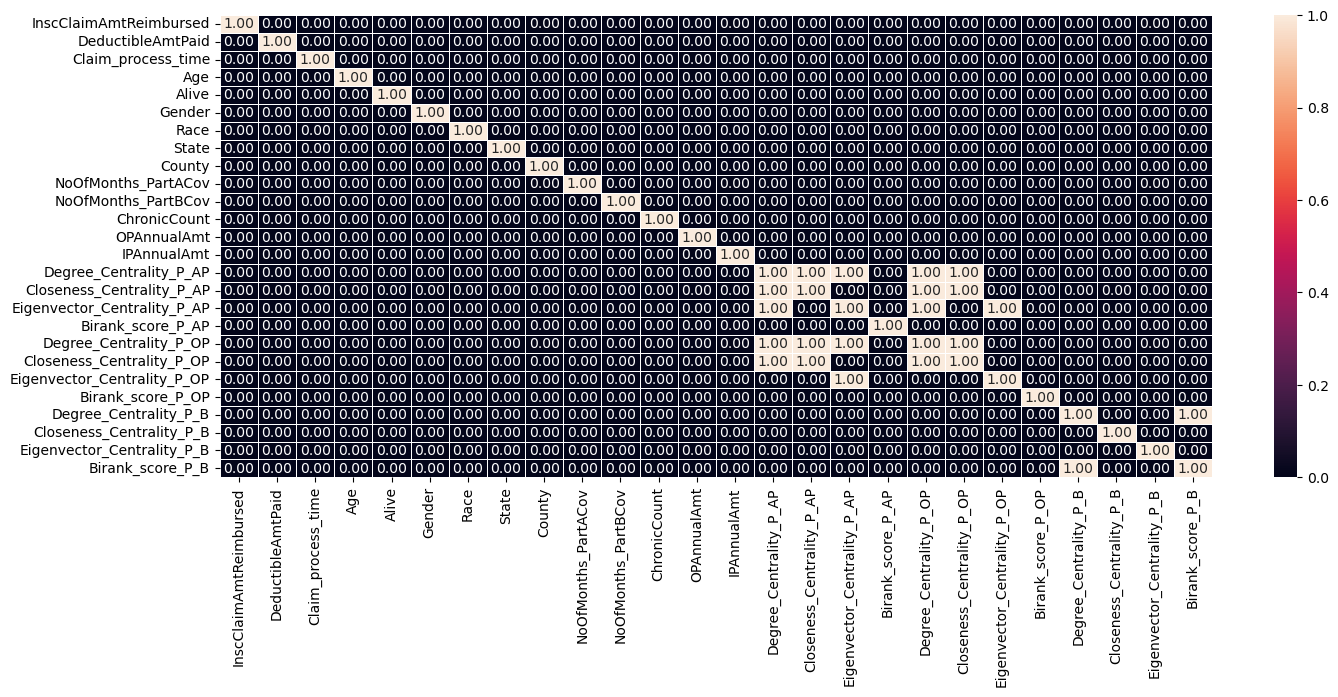

In [88]:
plt.figure(figsize=(16,6))
sns.heatmap(abs(df_pat_train.drop(['PotentialFraud'],axis=1).corr())>0.7,annot=True,fmt=".2f", linewidth=.5)
plt.show()

##### **Splitting And Encoding Data**

In [89]:
# Separating X and Y
y = df_pat_train['PotentialFraud']
X =df_pat_train.drop(['PotentialFraud'], axis=1)

In [90]:
label_e = LabelEncoder()
X_encoded = X.apply(label_e.fit_transform)

In [91]:
# Splting data into train and test
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

#### **Random Forest**

In [92]:
model = RandomForestClassifier()

parameter_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("List of best parameters for Random Forest are :{}".format(grid_search.best_params_))
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy for best Random Model is {}%".format(round(metrics.accuracy_score(y_test, y_pred)*100,2)))


# accuracy_chart[2] = ['I1','Random Forest',round(metrics.accuracy_score(y_test, y_pred)*100,2)]

List of best parameters for Random Forest are :{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for best Random Model is 86.49%


### **XG Boost**

In [93]:
model = xgb.XGBClassifier()
parameter_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, scoring='accuracy', cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("List of best parameters for XG Boost are :{}".format(grid_search.best_params_))

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the accuracy of the best model on the test set
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy for best XG Boost on test set is {}%".format(round(accuracy * 100, 2)))


List of best parameters for XG Boost are :{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy for best XG Boost on test set is 94.67%


### **Leiden Community Detection**

In [94]:
# Assuming 'df' is your DataFrame

# Step 1: Create a NetworkX graph
G = nx.Graph()

# Add nodes (beneficiaries, providers, physicians)
G.add_nodes_from(df_pat_train['BeneID'], type='beneficiary')
G.add_nodes_from(df_pat_train['Provider'], type='provider')
G.add_nodes_from(df_pat_train['AttendingPhysician'], type='physician')
G.add_nodes_from(df_pat_train['OperatingPhysician'], type='physician')

# Add edges (connections between beneficiaries and providers)
for index, row in df_pat_train.iterrows():
    G.add_edge(row['BeneID'], row['Provider'])
    G.add_edge(row['AttendingPhysician'], row['Provider'])
    G.add_edge(row['OperatingPhysician'], row['Provider'])

# Step 2: Apply Leiden community detection algorithm
partition = la.find_partition(G, la.ModularityVertexPartition)

# Step 3: Assign communities to nodes
communities = {}
for idx, community in enumerate(partition):
    for node in community:
        communities[node] = idx

# Add community information to DataFrame
df_pat_train['Community'] = df_pat_train['BeneID'].map(communities)

# Now, df['Community'] contains the community assignments for each node


NameError: name 'la' is not defined